### **Descarga e importe de bibliotecas**

In [1]:
%%capture
# Instalar y actualizar bibliotecas necesarias
!pip install kagglehub
!pip install roboflow
!pip install ultralytics

In [2]:
# Importar bibliotecas a usar
import os
import yaml
import random
import shutil
import kagglehub
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from roboflow import Roboflow
from ultralytics import YOLO
import cv2
import numpy as np

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### **Descarga y acondicionamiento de la base de datos de semillas**

In [3]:
# Descargar repositorio de aisladores
rf = Roboflow(api_key="3ioUIbqERJ2jEWElELQN")
project = rf.workspace("gcpds-tm2ae").project("seed-detection-edge")
version = project.version(2)
dataset = version.download("yolov11")
!mkdir datasets
!mv ./Seed-Detection-Edge-2 ./datasets

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Seed-Detection-Edge-2 in yolov11:: 100%|██████████| 6476/6476 [00:01<00:00, 4870.91it/s]


In [4]:
# Creación del directorio de las partes de la base de datos
data = {
    'path': './Seed-Detection-Edge-2',
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'nc': 2,
    'names': ['Germinated', 'No_germinated'],
    'roboflow': {
        'license': 'CC BY 4.0',
        'project': 'seed-detection-smrzf',
        'url': 'https://universe.roboflow.com/gcpds-tm2ae/seed-detection-edge/dataset/2',
        'version': '2',
        'workspace': 'gcpds-tm2ae'}
}

# Especificar el directorio del archivo
file_path = './datasets/Seed-Detection-Edge-2/data.yaml'

# Escribir la información sobre el archivo YAML
with open(file_path, 'w') as yaml_file:
    yaml.dump(data, yaml_file, default_flow_style=False)

### **Descarga del modelo entrenado e inferencia en imagen de evaluación**

In [5]:
# Descargar el modelo
model_path = kagglehub.model_download("lucasiturriago/yolov11m-seeds/pyTorch/segmentation")

# Especificar la carpeta de destino
output_folder = "./models"
os.makedirs(output_folder, exist_ok=True)

# Mover el modelo a la carpeta de destino
shutil.copy(model_path+'/yolo11m-seeds-seg.pt', output_folder)

'./models/yolo11m-seeds-seg.pt'

In [23]:
# Cargar YOLOv11 para segmentación de semillas

# Carga de modelo preentrenado
model = YOLO('./models/yolo11m-seeds-seg.pt')

In [24]:
# Ruta de la carpeta con las imágenes
image_folder_path = './datasets/Seed-Detection-Edge-2/test/images'

# Listar las imágenes de evaluación
image_paths = [os.path.join(image_folder_path, img) for img in os.listdir(image_folder_path) if img.endswith(('.png', '.jpg', '.jpeg'))]

# Seleccionar una imagen al azar
imagen_dir = image_paths[random.randint(0, len(image_paths)-1)]


image 1/1 /kaggle/working/datasets/Seed-Detection-Edge-2/test/images/2021-03-16_18_45_54_jpg.rf.6fe6311dd28b9116feb3472a4f58522b.jpg: 640x640 8 Germinateds, 18 No_germinateds, 1404.9ms
Speed: 2.8ms preprocess, 1404.9ms inference, 61.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict


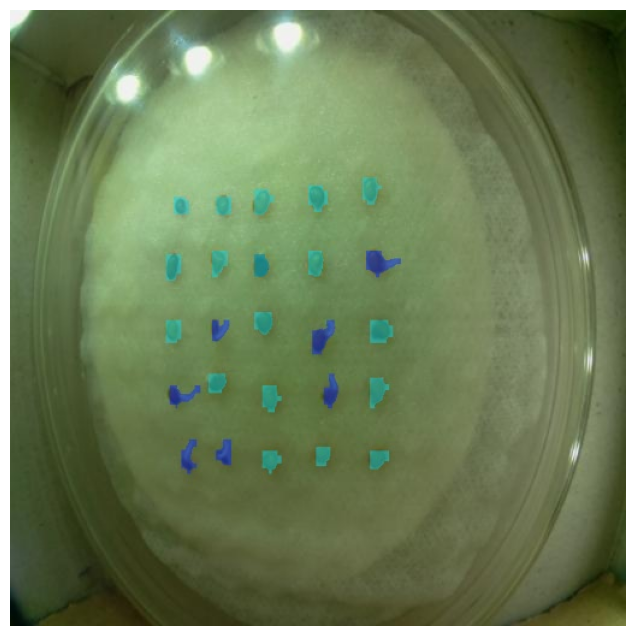

In [25]:
# Borrar resultados anteriores en caso de que existan
if os.path.exists('./runs/segment/predict'):
    shutil.rmtree('./runs/segment/predict')

# Realizar inferencia
result = model.predict(imagen_dir, save=True, imgsz=640, conf=0.4, show_boxes=False, show_labels=True)

# Ruta de la imagen con la inferencia del modelo
image_path = "./runs/segment/predict/"+imagen_dir.rsplit('/', 1)[-1]

# Cargar la imagen
image = mpimg.imread(image_path)

# Mostrar la imagen
plt.figure(figsize=(10, 8)) 
plt.imshow(image)
plt.axis('off')
plt.show()

### **Funciones para analisis de Metricas del modelo: "Dice Coefficient, Jaccard Index, Sensitivity, y Specificity"**

In [26]:
# Función para crear máscara a partir del archivo de etiquetas
def create_mask_from_label(label_path, image_shape):
    """
    Lee el archivo de etiqueta y crea una máscara binaria con la región marcada.
    image_shape: (alto, ancho)
    """
    mask = np.zeros(image_shape, dtype=np.uint8)
    if not os.path.exists(label_path):
        return mask  # Si no existe etiqueta, retorna máscara vacía.
    
    with open(label_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        parts = line.strip().split()
        # Si la línea tiene 5 elementos se asume caja delimitadora
        if len(parts) == 5:
            cls, x_center, y_center, w, h = map(float, parts)
            H, W = image_shape
            x_center *= W
            y_center *= H
            w *= W
            h *= H
            x1 = int(x_center - w/2)
            y1 = int(y_center - h/2)
            x2 = int(x_center + w/2)
            y2 = int(y_center + h/2)
            cv2.rectangle(mask, (x1, y1), (x2, y2), 1, -1)
        # Si tiene más de 5 números se asume polígono
        elif len(parts) > 5:
            # El primer valor es la clase y el resto son coordenadas normalizadas
            coords = list(map(float, parts[1:]))
            H, W = image_shape
            pts = []
            for i in range(0, len(coords), 2):
                pts.append([int(coords[i] * W), int(coords[i+1] * H)])
            pts = np.array([pts], dtype=np.int32)
            cv2.fillPoly(mask, pts, 1)
    return mask

# Función para crear la máscara predicha a partir del resultado del modelo
def create_mask_from_prediction(result, image_shape):
    """
    A partir de la salida de model.predict (suponiendo que result es una lista de objetos Result)
    y usando result[0].masks.xy (lista de polígonos), se crea una máscara binaria.
    """
    mask = np.zeros(image_shape, dtype=np.uint8)
    # Verificar que se hayan detectado máscaras
    if result[0].masks is not None and result[0].masks.xy is not None:
        for poly in result[0].masks.xy:
            # Asegurarse de que las coordenadas ya estén en píxeles
            pts = np.array(poly, dtype=np.int32)
            pts = pts.reshape((-1,1,2))
            cv2.fillPoly(mask, [pts], 1)
    return mask

# Funciones para calcular las métricas con NumPy
def dice_coefficient(gt, pred, smooth=1e-7):
    intersection = np.sum(gt * pred)
    return (2. * intersection + smooth) / (np.sum(gt) + np.sum(pred) + smooth)

def jaccard_index(gt, pred, smooth=1e-7):
    intersection = np.sum(gt * pred)
    union = np.sum(gt) + np.sum(pred) - intersection
    return (intersection + smooth) / (union + smooth)

def sensitivity_metric(gt, pred, smooth=1e-7):
    tp = np.sum(gt * pred)
    fn = np.sum(gt) - tp
    return (tp + smooth) / (tp + fn + smooth)

def specificity_metric(gt, pred, smooth=1e-7):
    tn = np.sum((1-gt) * (1-pred))
    fp = np.sum(1-gt) - tn
    return (tn + smooth) / (tn + fp + smooth)

In [27]:
# Directorios de imágenes y etiquetas del conjunto de test
test_images_dir = './datasets/Seed-Detection-Edge-2/test/images'
test_labels_dir = './datasets/Seed-Detection-Edge-2/test/labels'

# Listar las imágenes de test
test_image_paths = [os.path.join(test_images_dir, img) 
                    for img in os.listdir(test_images_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

# Listas para almacenar resultados de las métricas
dice_scores = []
jaccard_scores = []
sensitivity_scores = []
specificity_scores = []

# Iterar sobre cada imagen del conjunto de test
for img_path in test_image_paths:
    # Leer la imagen original para conocer su tamaño
    img = cv2.imread(img_path)
    if img is None:
        continue
    # Convertir de BGR a RGB (opcional, para visualización)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W, _ = img.shape
    
    # Ruta del archivo de etiquetas correspondiente (se asume misma base de nombre y extensión .txt)
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(test_labels_dir, base_name + '.txt')
    
    # Crear la máscara de ground truth a partir de la etiqueta
    gt_mask = create_mask_from_label(label_path, (H, W))
    
    # Realizar la predicción con el modelo para la imagen actual
    # Nota: se usa conf=0.4 y imgsz=640; ajustar parámetros si es necesario.
    results = model.predict(img_path, conf=0.4, imgsz=640)
    
    # Crear la máscara predicha a partir de los resultados
    pred_mask = create_mask_from_prediction(results, (H, W))
    
    # Calcular las métricas
    dice_val = dice_coefficient(gt_mask, pred_mask)
    jaccard_val = jaccard_index(gt_mask, pred_mask)
    sensitivity_val = sensitivity_metric(gt_mask, pred_mask)
    specificity_val = specificity_metric(gt_mask, pred_mask)
    
    # Almacenar los resultados
    dice_scores.append(dice_val)
    jaccard_scores.append(jaccard_val)
    sensitivity_scores.append(sensitivity_val)
    specificity_scores.append(specificity_val)
    
# Convertir listas a arrays para calcular la media y desviación
dice_scores = np.array(dice_scores)
jaccard_scores = np.array(jaccard_scores)
sensitivity_scores = np.array(sensitivity_scores)
specificity_scores = np.array(specificity_scores)

# Imprimir las métricas globales
print("Model's performance metrics:")
print(f"Dice Coefficient mean: {dice_scores.mean():.5f}, standard deviation: {dice_scores.std():.5f}")
print(f"Jaccard Index mean: {jaccard_scores.mean():.5f}, standard deviation: {jaccard_scores.std():.5f}")
print(f"Sensitivity mean: {sensitivity_scores.mean():.5f}, standard deviation: {sensitivity_scores.std():.5f}")
print(f"Specificity mean: {specificity_scores.mean():.5f}, standard deviation: {specificity_scores.std():.5f}")


image 1/1 /kaggle/working/datasets/Seed-Detection-Edge-2/test/images/zm7_12_img084_jpg.rf.7c07b076f7bd8bbec7c1b10006d95169.jpg: 640x640 8 Germinateds, 3 No_germinateds, 1422.7ms
Speed: 3.3ms preprocess, 1422.7ms inference, 27.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/working/datasets/Seed-Detection-Edge-2/test/images/zm7_11_img062_jpg.rf.77be72e89e05c4d1d0664d0bf255082d.jpg: 640x640 10 No_germinateds, 1512.8ms
Speed: 2.9ms preprocess, 1512.8ms inference, 32.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/working/datasets/Seed-Detection-Edge-2/test/images/pg7_12_img013_jpg.rf.d4a640cc25352ceb95e64de3f2f81b5c.jpg: 640x640 10 No_germinateds, 1440.2ms
Speed: 2.9ms preprocess, 1440.2ms inference, 26.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/working/datasets/Seed-Detection-Edge-2/test/images/S27-05-2022-05_54_24_jpg.rf.5d016b7368d8e41807f95c789f2a7b0c.jpg: 640x640 9 Germinateds, 16 No_germinateds, 1530.3ms
Spee